## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import random
import time
from dataclasses import dataclass
from enum import Enum

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch import optim
from torchvision import transforms
from torchinfo import summary

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
import h5py
import tifffile
import tqdm




### <font style="color:lightblue">Functions</font>

In [2]:


def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)


def plotData(dataY, rangeY=None, dataYR=None, rangeYR=None,
             dataX=None, rangeX=None, rangeP=None,
             figsize=(16,8), saveTo=None, show=True):

    if type(dataY) is np.ndarray :
        plotData((dataY,), rangeY=rangeY, dataYR=dataYR, rangeYR=rangeYR,
             dataX=dataX, rangeX=rangeX, rangeP=rangeP,
             figsize=figsize, saveTo=saveTo, show=show)
        return
    if type(dataYR) is np.ndarray :
        plotData(dataY, rangeY=rangeY, dataYR=(dataYR,), rangeYR=rangeYR,
             dataX=dataX, rangeX=rangeX, rangeP=rangeP,
             figsize=figsize, saveTo=saveTo, show=show)
        return
    if type(dataY) is not tuple :
        eprint(f"Unknown data type to plot: {type(dataY)}.")
        return
    if type(dataYR) is not tuple and dataYR is not None:
        eprint(f"Unknown data type to plot: {type(dataYR)}.")
        return

    last = min( len(data) for data in dataY )
    if dataYR is not None:
        last = min( last,  min( len(data) for data in dataYR ) )
    if dataX is not None:
        last = min(last, len(dataX))
    if rangeP is None :
        rangeP = (0,last)
    elif type(rangeP) is int :
        rangeP = (0,rangeP) if rangeP > 0 else (-rangeP,last)
    elif type(rangeP) is tuple :
        rangeP = ( 0    if rangeP[0] is None else rangeP[0],
                   last if rangeP[1] is None else rangeP[1],)
    else :
        eprint(f"Bad data type on plotData input rangeP: {type(rangeP)}")
        raise Exception(f"Bug in the code.")
    rangeP = np.s_[ max(0, rangeP[0]) : min(last, rangeP[1]) ]
    if dataX is None :
        dataX = np.arange(rangeP.start, rangeP.stop)

    plt.style.use('default')
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.xaxis.grid(True, 'both', linestyle='dotted')
    if rangeX is not None :
        ax1.set_xlim(rangeX)
    else :
        ax1.set_xlim(rangeP.start,rangeP.stop-1)

    ax1.yaxis.grid(True, 'both', linestyle='dotted')
    nofPlots = len(dataY)
    if rangeY is not None:
        ax1.set_ylim(rangeY)
    colors = [ matplotlib.colors.hsv_to_rgb((hv/nofPlots, 1, 1)) for hv in range(nofPlots) ]
    for idx , data in enumerate(dataY):
        ax1.plot(dataX, data[rangeP], linestyle='-',  color=colors[idx])

    if dataYR is not None : # right Y axis
        ax2 = ax1.twinx()
        ax2.yaxis.grid(True, 'both', linestyle='dotted')
        nofPlots = len(dataYR)
        if rangeYR is not None:
            ax2.set_ylim(rangeYR)
        colors = [ matplotlib.colors.hsv_to_rgb((hv/nofPlots, 1, 1)) for hv in range(nofPlots) ]
        for idx , data in enumerate(dataYR):
            ax2.plot(dataX, data[rangeP], linestyle='dashed',  color=colors[idx])

    if saveTo:
        fig.savefig(saveTo)
    if not show:
        plt.close(fig)


def plotImage(image) :
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    plt.show()


def plotImages(images) :
    for i, img in enumerate(images) :
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis("off")
    plt.show()


def sliceShape(shape, sl) :
    if type(shape) is int :
        shape = torch.Size([shape])
    if type(sl) is tuple :
        if len(shape) != len(sl) :
            raise Exception(f"Different sizes of shape {shape} and sl {sl}")
        out = []
        for i in range(0, len(shape)) :
            indeces = sl[i].indices(shape[i])
            out.append(indeces[1]-indeces[0])
        return out
    elif type(sl) is slice :
        indeces = sl.indices(shape[0])
        return indeces[1]-indeces[0]
    else :
        raise Exception(f"Incompatible object {sl}")


def tensorStat(stat) :
    print(stat.mean().item(), stat.std().item(), (stat.std()/stat.mean()).item(), stat.min().item(), stat.max().item())





### <font style="color:lightblue">Configs</font>

In [69]:
def set_seed(SEED_VALUE):
    torch.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    np.random.seed(SEED_VALUE)

seed = 7
set_seed(seed)

@dataclass(frozen=True)
class TCfg:
    exec = 1
    device: torch.device = f"cuda:{exec}"
    nofEpochs: int = 2048
    latentDim: int = 64
    batchSize: int = 4096
    labelSmoothFac: float = 1 # For Real labels (or set to 1.0 for no smoothing).
    learningRateD: float = 0.00002
    learningRateG: float = 0.00002
    historyHDF = f"train_{exec}.hdf"

class DCfg:
    readSh = (80,80)
    sinoSh = (10,10)
    sinoSize = math.prod(sinoSh)
    gapSh = (sinoSh[0],sinoSh[0]//5)
    gapSize = math.prod(gapSh)
    gapRngX = np.s_[ sinoSh[1]//2 - gapSh[1]//2 : sinoSh[1]//2 + gapSh[1]//2 ]
    gapRng = np.s_[ : , gapRngX ]
    disRng = np.s_[ gapSh[1]:-gapSh[1] , gapRngX ]




## <font style="color:lightblue">Data</font>

### <font style="color:lightblue">Raw Read</font>

In [4]:

class StripesFromHDF :

    def __init__(self, sampleName, maskName, bgName=None, dfName=None, loadToMem=True):

        sampleHDF = sampleName.split(':')
        if len(sampleHDF) != 2 :
            raise Exception(f"String \"{sampleName}\" does not represent an HDF5 format.")
        with h5py.File(sampleHDF[0],'r') as trgH5F:
            if  sampleHDF[1] not in trgH5F.keys():
                raise Exception(f"No dataset '{sampleHDF[1]}' in input file {sampleHDF[0]}.")
            self.data = trgH5F[sampleHDF[1]]
            if not self.data.size :
                raise Exception(f"Container \"{sampleName}\" is zero size.")
            self.sh = self.data.shape
            if len(self.sh) != 3 :
                raise Exception(f"Dimensions of the container \"{sampleName}\" is not 3 {self.sh}.")
            self.fsh = self.sh[1:3]
            self.volume = None
            if loadToMem :
                self.volume = np.empty(self.sh, dtype=np.float32)
                self.data.read_direct(self.volume)
                trgH5F.close()

            def loadImage(imageName) :
                if not imageName:
                    return None
                imdata = imread(imageName).astype(np.float32)
                if len(imdata.shape) == 3 :
                    imdata = np.mean(imdata[:,:,0:3], 2)
                #imdata = imdata.transpose()
                if imdata.shape != self.fsh :
                    raise Exception(f"Dimensions of the input image \"{imageName}\" {imdata.shape} "
                                    f"do not match the face of the container \"{sampleName}\" {self.fsh}.")
                return imdata


            self.mask = loadImage(maskName)
            if self.mask is None :
                self.mask = np.ones(self.fsh, dtype=np.uint8)
            self.mask = self.mask.astype(bool)
            self.bg = loadImage(bgName)
            self.df = loadImage(dfName)
            if self.bg is not None :
                if self.df is not None:
                    self.bg -= self.df
                self.mask  &=  self.bg > 0.0

            self.allIndices = []
            for yCr in range(0,self.fsh[0]) :
                for xCr in range(0,self.fsh[1]) :
                    idx = np.s_[yCr,xCr]
                    if self.mask[idx] :
                        if self.volume is not None :
                            if self.df is not None :
                                self.volume[:,*idx] -= self.df[idx]
                            if self.bg is not None :
                                self.volume[:,*idx] /= self.bg[idx]
                        if  xCr + DCfg.readSh[1] < self.fsh[1] \
                        and np.all( self.mask[yCr,xCr+1:xCr+DCfg.readSh[1]] ) :
                            self.allIndices.append(idx)

    def get_dataset(self, transform=None) :
        class Sinos(torch.utils.data.Dataset) :
            def __init__(self, root, transform=None):
                self.container = root
                self.transform = transforms.Compose([transforms.ToTensor(), transform]) \
                    if transform else transforms.ToTensor()
            def __len__(self):
                return len(self.container.allIndices)
            def __getitem__(self, index):
                idx = self.container.allIndices[index]
                xyrng=np.s_[ idx[0], idx[1]:idx[1]+DCfg.readSh[1] ]
                if self.container.volume is not None :
                    data = self.container.volume[:, *xyrng]
                else :
                    data = self.container.data[:, *xyrng]
                    if self.container.df is not None :
                        data -= self.container.df[None,*xyrng]
                    if self.container.bg is not None :
                        data /= self.container.bg[None,*xyrng]
                theta = random.randint(0,data.shape[0]-DCfg.readSh[0]-1)
                data = data[theta:theta+DCfg.readSh[0],:]
                if self.transform :
                    data = self.transform(data)
                return data
        return Sinos(self, transform)

sinoRoot = StripesFromHDF("/mnt/ssdData/4176862R_Eig_Threshold-4keV/output/SAMPLE_Y0_BG.hdf:/data",
                          "/mnt/ssdData/4176862R_Eig_Threshold-4keV/output/maskc.tif",
                          None, None)



### <font style="color:lightblue">Transform</font>

In [5]:
dataTransform =  transforms.Compose([
    transforms.Resize(DCfg.sinoSh),
    transforms.Normalize(mean=(0.5), std=(1))
])
trainSet = sinoRoot.get_dataset(dataTransform)

### <font style="color:lightblue">Predict</font>

In [6]:

#preKernel = None
#preWeights = None
#def preConv(images) :
#    global preKernel, preWeights
#    input = images[...,DCfg.gapSh[1]:-DCfg.gapSh[1]].clone()
#    input.to(images.device)
#    if len(input.shape) == 2 :
#        input = input.unsqueeze(0)
#    if len(input.shape) == 3 :
#        input = input.unsqueeze(1)
#    input[...,DCfg.gapSh[1]:-DCfg.gapSh[1]] = 0
#    if preKernel is None :
#        preKernel = torch.ones((2*DCfg.gapSh[1]+1,2*DCfg.gapSh[1]+1), device=images.device)
#        prof = torch.zeros(DCfg.gapSh[1], device=images.device)
#        for pp in range(DCfg.gapSh[1]) :
#            prof[pp] = math.exp( - 6 * (pp+1)**2 / DCfg.gapSh[1]**2 )
#        preKernel[:,0:DCfg.gapSh[1]] *= prof
#        preKernel[:,DCfg.gapSh[1]+1:]  *= prof
#        preKernel[0:DCfg.gapSh[1],:] *= prof.unsqueeze(1)
#        preKernel[DCfg.gapSh[1]+1:,:]  *= prof.unsqueeze(1)
#        preKernel = preKernel.unsqueeze(0).unsqueeze(0)
#        img101 = torch.ones(DCfg.sinoSh,device=images.device)
#        preWeights = preConv(img101).to(images.device)
#    else :
#        preKernel = preKernel.to(images.device)
#        if not preWeights is None :
#            preWeights = preWeights.to(images.device)
#
#    res = torch.nn.functional.conv2d(input[...,],preKernel,padding=(DCfg.gapSh[1],0))
#    if len(images.shape) < 4 :
#        res = res.squeeze(1)
#    if len(images.shape) < 3 :
#        res = res.squeeze(0)
#    if not preWeights is None :
#        res /= preWeights
#    return res
#


preKernels = {}
preWeights = None
def preConv(images) :
    global preKernels, preWeights
    input = images[...,DCfg.gapSh[1]:-DCfg.gapSh[1]].clone()
    input.to(images.device)
    if len(input.shape) == 2 :
        input = input.unsqueeze(0)
    if len(input.shape) == 3 :
        input = input.unsqueeze(1)
    input[...,DCfg.gapSh[1]:-DCfg.gapSh[1]] = 0
    if not preKernels :
        for ln in range( 0, DCfg.gapSh[1]//2 + DCfg.gapSh[1]%2) :
            rd = 1 + 2*ln
            sz = 1 + 2*rd
            preKernel = torch.ones((sz,sz), device=images.device)
            prof = torch.zeros(rd, device=images.device)
            for pp in range(rd) :
                prof[pp] = math.exp( - (pp+1)**2 / rd**2 )
            preKernel[:,0:rd] *= prof
            preKernel[:,rd+1:]  *= prof
            preKernel[0:rd,:] *= prof.unsqueeze(1)
            preKernel[rd+1:,:]  *= prof.unsqueeze(1)
            preKernels[ln] = preKernel.unsqueeze(0).unsqueeze(0)
        #preKernel = torch.sqrt(preKernel).unsqueeze(0).unsqueeze(0)
        img101 = torch.ones(DCfg.sinoSh,device=images.device)
        preWeights = preConv(img101).to(images.device)
    else :
        for sz in preKernels :
            preKernels[sz] = preKernels[sz].to(images.device)
        if not preWeights is None :
            preWeights = preWeights.to(images.device)

    res = torch.empty((input.shape[0], input.shape[1], *DCfg.gapSh), device=images.device)
    for lc in range(0,DCfg.gapSh[1]) :
        ln = min(lc, DCfg.gapSh[1]-lc-1)
        rd = 1 + 2*ln
        preKernel = preKernels[ln]
        inputln = input[...,DCfg.gapSh[1]+lc-rd:DCfg.gapSh[1]+lc+rd+1]
        resln = torch.nn.functional.conv2d(inputln,preKernel,padding=(rd,0))
        res[...,lc] = resln.squeeze(3)
    #res = torch.nn.functional.conv2d(input,preKernel,padding=(DCfg.gapSh[1],0))
    if len(images.shape) < 4 :
        res = res.squeeze(1)
    if len(images.shape) < 3 :
        res = res.squeeze(0)
    if not preWeights is None :
        res /= preWeights
    return res







### <font style="color:lightblue">Show</font>

0.3025965392589569 0.23866863548755646 0.7887355089187622 -0.16866731643676758 0.5188634395599365


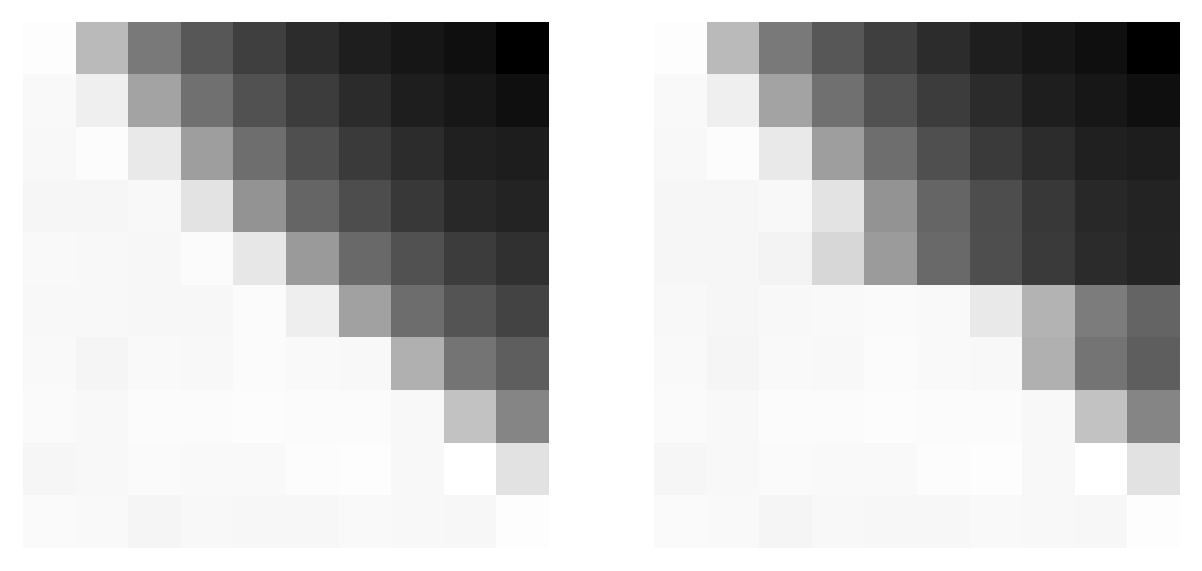

In [9]:
refImages = None
refNoises = None

def showMe() :
    global refImages, refNoises
    randIdx = random.randint(0,len(trainSet)-1) # 835526 735307
    image = trainSet[randIdx].squeeze()
    tensorStat(image)
    image = image.to(TCfg.device)

    #start = time.time()
    patch = preConv(image)
    #print(start - time.time())
    pimage = image.clone()
    pimage[...,*DCfg.gapRng] = patch
    plotImages([image.transpose(0,1).cpu(),pimage.transpose(0,1).cpu()])

    #tifffile.imwrite(f"tmp_{TCfg.exec}.tif", image.numpy())
    refImages = torch.stack((image,pimage)).to(TCfg.device)
    refNoises = torch.randn((2,TCfg.latentDim)).to(TCfg.device)

showMe()


## <font style="color:lightblue">Models</font>

In [10]:
def fillWheights(seq) :
    for wh in seq :
        if hasattr(wh, 'weight') :
            torch.nn.init.xavier_uniform_(wh.weight)

### <font style="color:lightblue">Save/Load model</font>

In [11]:
def save_model(model, device, model_path):
    if not device == 'cpu':
        model.to('cpu')
    torch.save(model.state_dict(), model_path)
    if not device == 'cpu':
        model.to(device)
    return

def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    return model


def addToHDF(filename, containername, data) :
    if len(data.shape) == 2 :
        data=np.expand_dims(data, 0)
    if len(data.shape) != 3 :
        raise Exception(f"Not appropriate input array size {data.shape}.")

    with h5py.File(filename,'a') as file :

        if  containername not in file.keys():
            dset = file.create_dataset(containername, data.shape,
                                       maxshape=(None,data.shape[1],data.shape[2]),
                                       dtype='f')
            dset[()] = data
            return

        dset = file[containername]
        csh = dset.shape
        if csh[1] != data.shape[1] or csh[2] != data.shape[2] :
            raise Exception(f"Shape mismatch: input {data.shape}, file {dset.shape}.")
        msh = dset.maxshape
        newLen = csh[0] + data.shape[0]
        if msh[0] is None or msh[0] >= newLen :
            dset.resize(newLen, axis=0)
        else :
            raise Exception(f"Insufficient maximum shape {msh} to add data"
                            f" {data.shape} to current volume {dset.shape}.")
        dset[csh[0]:newLen,...] = data
        file.close()


    return 0

### <font style="color:lightblue">Generator</font>

In [12]:


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.noise2latent = nn.Sequential(
            nn.Linear(TCfg.latentDim, DCfg.sinoSize*63),
            nn.ReLU(),
            nn.Unflatten( 1, (63,) + DCfg.sinoSh )
        )
        fillWheights(self.noise2latent)

        self.encode = nn.Sequential(

            nn.Conv2d(64, 128, 3),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 3),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 3),
            nn.LeakyReLU(0.2),


        )
        fillWheights(self.encode)


        self.link = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8192, 8192),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (512, 4, 4)),
        )
        fillWheights(self.link)


        self.decode = nn.Sequential(

            nn.ConvTranspose2d(512, 256, (3,1)),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, (3,1)),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, (3,1)),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 1, (1,3)),
            nn.Tanh()

        )
        fillWheights(self.decode)

        self.body = nn.Sequential(
            self.encode,
            self.link,
            self.decode
        )


    def forward(self, input):
        images, noises = input
        if images.dim() == 3:
            images = images.unsqueeze(1)
        latent = self.noise2latent(noises)
        modelIn = torch.cat((images,latent),dim=1)
        modelIn[:,0,*DCfg.gapRng] = preConv(images[:,0,:,:])
        patches = self.body(modelIn)
        #return patches
        mIn = modelIn[:,0,*DCfg.gapRng].unsqueeze(1)
        #tensorStat(mIn[:,DCfg.gapSh[1]:-DCfg.gapSh[1]])
        #tensorStat(patches[:,DCfg.gapSh[1]:-DCfg.gapSh[1]])
        patches = mIn + torch.where( patches < 0 , patches * (mIn+0.5) , patches )
        #tensorStat(patches[:,DCfg.gapSh[1]:-DCfg.gapSh[1]])
        modelOut = torch.cat((images[:,:,:,:DCfg.gapRngX.start], patches, images[:,:,:,DCfg.gapRngX.stop:]),dim=3)
        return modelOut.squeeze(1)


generator = Generator()
#generator = load_model(generator, model_path=f"model_{TCfg.exec}_gen.pt" )
generator.to(TCfg.device)
model_summary = summary(generator, input_data=[ [refImages, refNoises] ] ).__str__()
print(model_summary)
try : os.remove(TCfg.historyHDF)
except : pass




Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [2, 10, 10]               --
├─Sequential: 1-1                        [2, 63, 10, 10]           --
│    └─Linear: 2-1                       [2, 6300]                 409,500
│    └─ReLU: 2-2                         [2, 6300]                 --
│    └─Unflatten: 2-3                    [2, 63, 10, 10]           --
├─Sequential: 1-2                        [2, 1, 10, 2]             --
│    └─Sequential: 2-4                   [2, 512, 4, 4]            --
│    │    └─Conv2d: 3-1                  [2, 128, 8, 8]            73,856
│    │    └─LeakyReLU: 3-2               [2, 128, 8, 8]            --
│    │    └─Conv2d: 3-3                  [2, 256, 6, 6]            295,168
│    │    └─LeakyReLU: 3-4               [2, 256, 6, 6]            --
│    │    └─Conv2d: 3-5                  [2, 512, 4, 4]            1,180,160
│    │    └─LeakyReLU: 3-6               [2, 512, 4, 4]         

### <font style="color:lightblue">Discriminator</font>

In [13]:

class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.body = nn.Sequential(

            nn.Conv2d(1, 128, 3),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 3),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 3),
            nn.LeakyReLU(0.2),

        )
        fillWheights(self.body)

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(8192, 128),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        fillWheights(self.head)


    def forward(self, images):
        if images.dim() == 3:
            images = images.unsqueeze(1)
        modelIn = images.clone()
        modelIn[...,0:DCfg.gapSh[1],DCfg.gapRngX] = 0 # torch.randn(images.shape[0],1,DCfg.gapSh[1],DCfg.gapSh[1])
        modelIn[...,-DCfg.gapSh[1]:,DCfg.gapRngX] = 0 # torch.randn(images.shape[0],1,DCfg.gapSh[1],DCfg.gapSh[1])
        convRes = self.body(modelIn)
        res = self.head(convRes)
        return res

discriminator = Discriminator()
#discriminator = load_model(discriminator, model_path=f"model_{TCfg.exec}_dis.pt" )
discriminator.to(TCfg.device)
model_summary = summary(discriminator, input_data=refImages ).__str__()
print(model_summary)




Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [2, 1]                    --
├─Sequential: 1-1                        [2, 512, 4, 4]            --
│    └─Conv2d: 2-1                       [2, 128, 8, 8]            1,280
│    └─LeakyReLU: 2-2                    [2, 128, 8, 8]            --
│    └─Conv2d: 2-3                       [2, 256, 6, 6]            295,168
│    └─LeakyReLU: 2-4                    [2, 256, 6, 6]            --
│    └─Conv2d: 2-5                       [2, 512, 4, 4]            1,180,160
│    └─LeakyReLU: 2-6                    [2, 512, 4, 4]            --
├─Sequential: 1-2                        [2, 1]                    --
│    └─Flatten: 2-7                      [2, 8192]                 --
│    └─Dropout: 2-8                      [2, 8192]                 --
│    └─Linear: 2-9                       [2, 128]                  1,048,704
│    └─Linear: 2-10                      [2, 1]                

### <font style="color:lightblue">Test</font>

[0.5358107 0.5358412]
-0.04043395072221756 0.011804810725152493 -0.2919529378414154 -0.056030094623565674 -0.022628791630268097


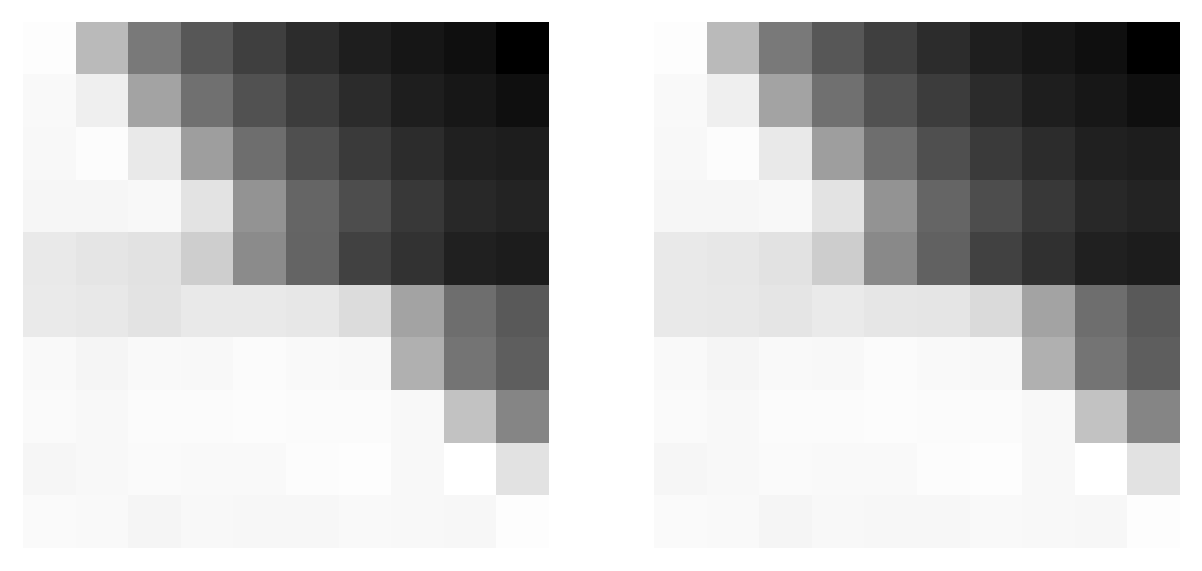

In [14]:
generator.eval()
discriminator.eval()
mgens = generator([refImages,refNoises])
liks = discriminator(mgens)
print(liks.detach().cpu().squeeze().numpy())
tensorStat( mgens[1,*DCfg.disRng] - refImages[1,*DCfg.disRng] )
plotImages((mgens[0,...].detach().cpu().squeeze().transpose(0,1),
            mgens[1,...].detach().cpu().squeeze().transpose(0,1)))


## <font style="color:lightblue">Train</font>

### <font style="color:lightblue">Metrics</font>

In [47]:
BCE = nn.BCELoss(reduction='none')

def loss_func(y_true, y_pred, weights=None):
    loss = BCE(y_pred, y_true)
    summ = len(loss)
    if not weights is None :
        loss *= weights.unsqueeze(1)
        summ = weights.sum()
    return loss.sum() / summ


### <font style="color:lightblue">Optimizers</font>

In [48]:

optimizer_G = optim.Adam(
    generator.parameters(),
    lr=TCfg.learningRateG,
    betas=(0.5, 0.999)
)
optimizer_D = optim.Adam(
    discriminator.parameters(),
    lr=TCfg.learningRateD,
    betas=(0.5, 0.999)
)

### <font style="color:lightblue">Train step</font>

In [85]:

def generate_images(images) :
    noise = torch.randn(images.shape[0], TCfg.latentDim).to(TCfg.device)
    outImages = generator((images, noise))
    return outImages

torch.autograd.set_detect_anomaly(True)

class TrainInfo:
    bestRealImage = None
    bestRealPrediction = 0
    bestRealWght = 0
    worstRealImage = None
    worstRealPrediction = 0
    worstRealWght = 0
    bestFakeImage = None
    bestFakePrediction = 0
    bestFakeWght = 0
    worstFakeImage = None
    worstFakePrediction = 0
    worstFakeWght = 0
    ratReal = 0.0
    ratFake = 0.0
    totalImages = 0
    iterations = 0
    disPerformed = 0
    genPerformed = 0


trainDis = True
trainGen = True
def train_step(images):
    global trainDis, trainGen
    TrainInfo.iterations += 1

    discriminator.eval()
    generator.eval()

    nofIm = images.shape[0]
    images = images.squeeze(1).to(TCfg.device)
    means = images.mean(dim=(1,2)).squeeze() + 0.5
    stdds = images.std(dim=(1,2)).squeeze()
    absWeights = means + 1
    absWeights /= absWeights.sum()
    disWeights = stdds / means
    disWeights /= disWeights.sum()
    weights = absWeights + disWeights
    weights /= weights.sum()
    fakeImages = generate_images(images)

    generator.eval()
    if trainDis :
        discriminator.train()
        optimizer_D.zero_grad()
    y_pred_real = discriminator(images)
    y_pred_fake = discriminator(fakeImages)
    y_pred_both = torch.cat((y_pred_real, y_pred_fake), dim=0)
    labels = torch.cat( (
        torch.full((nofIm, 1),  TCfg.labelSmoothFac),
        torch.zeros(nofIm, 1) ),
        dim=0
    ).to(TCfg.device)
    D_loss = None
    dweights = torch.cat( (weights, weights) )
    if trainDis :
        TrainInfo.disPerformed += 1
        D_loss = loss_func(labels, y_pred_both, dweights )
        D_loss.backward()
        optimizer_D.step()
    else :
        with torch.no_grad():
            D_loss = loss_func(labels, y_pred_both, torch.cat( (weights, weights) ))

    ratReal = torch.count_nonzero(y_pred_real > 0.5)/nofIm
    ratFake = torch.count_nonzero(y_pred_fake > 0.5)/nofIm
    trainGen = ratReal > 0.5 and ratFake < 0.5

    G_loss = None
    if trainGen:
        discriminator.eval()
        if trainGen :
            generator.train()
            optimizer_G.zero_grad()
        fakeImages = generate_images(images)
        y_pred_fake = discriminator(fakeImages)
        labels = torch.ones(nofIm, 1).to(TCfg.device)
        if trainGen :
            TrainInfo.genPerformed += 1
            G_loss = loss_func(labels, y_pred_fake, weights)
            G_loss.backward()
            optimizer_G.step()
        ratFake = torch.count_nonzero(y_pred_fake > 0.5)/nofIm
        trainDis = ratFake > 0.1
    else :
        labels = torch.ones(nofIm, 1).to(TCfg.device)
        with torch.no_grad() :
            G_loss = loss_func(labels, y_pred_fake, weights)
        optimizer_D.zero_grad()
        trainDis = True

    discriminator.eval()
    generator.eval()

    idx = y_pred_real.argmax()
    TrainInfo.bestRealImage = images[idx,...]
    TrainInfo.bestRealPrediction = y_pred_real[idx].item()
    TrainInfo.bestRealWght = nofIm*weights[idx]
    idx = y_pred_real.argmin()
    TrainInfo.worstRealImage = images[idx,...]
    TrainInfo.worstRealPrediction =  y_pred_real[idx].item()
    TrainInfo.worstRealWght = nofIm*weights[idx]
    idx = y_pred_fake.argmax()
    TrainInfo.bestFakeImage = fakeImages[idx,...]
    TrainInfo.bestFakePrediction = y_pred_fake[idx].item()
    TrainInfo.bestFakeWght = nofIm*weights[idx]
    idx = y_pred_fake.argmin()
    TrainInfo.worstFakeImage = fakeImages[idx,...]
    TrainInfo.worstFakePrediction = y_pred_fake[idx].item()
    TrainInfo.worstFakeWght = nofIm*weights[idx]
    TrainInfo.ratReal += ratReal * nofIm
    TrainInfo.ratFake += ratFake * nofIm
    TrainInfo.totalImages += nofIm

    return D_loss, G_loss




### <font style="color:lightblue">Trainer</font>

In [86]:


G_LOSS = []
D_LOSS = []

def train(dataloader, epochs):

    discriminator.to(TCfg.device)
    generator.to(TCfg.device)
    refImages.to(TCfg.device)
    refNoises.to(TCfg.device)

    for epoch in range(epochs):

        generator.train()
        discriminator.train()
        start = time.time()
        lastUpdateTime = start
        D_loss_list, G_loss_list = [], []

        pit = -1
        for it , images in tqdm.tqdm(enumerate(dataloader), total=int(len(dataloader))):

            images = images.to(TCfg.device)
            D_loss, G_loss = train_step(images)
            D_loss_list.append(D_loss)
            G_loss_list.append(G_loss)

            #if not it or it == len(dataloader)-1 or time.time() - lastUpdateTime > 60 :
            if it == len(dataloader)-1:
                lastUpdateTime = time.time()
                its = it-pit
                print(f"Epoch: {epoch}."
                      f" Discriminator loss: {D_loss:.3f} "
                      f"({TrainInfo.ratReal/TrainInfo.totalImages:.3f} / "
                      f"{TrainInfo.disPerformed/TrainInfo.iterations:.3f}), "
                      f" Generator loss: {G_loss:.3f} "
                      f"({TrainInfo.ratFake/TrainInfo.totalImages:.3f} / "
                      f"{TrainInfo.genPerformed/TrainInfo.iterations:.3f}).")
                TrainInfo.iterations = 0
                TrainInfo.totalImages = 0
                TrainInfo.ratReal = 0
                TrainInfo.ratFake = 0
                TrainInfo.genPerformed = 0
                TrainInfo.disPerformed = 0
                pit = it
                fourImages = np.ones( (2*DCfg.sinoSh[1] + DCfg.gapSh[1] ,
                                       3*DCfg.sinoSh[0] + 2*DCfg.gapSh[1]), dtype=np.float32  )
                def addImage(clmn, row, img) :
                    fourImages[ row * ( DCfg.sinoSh[1]+DCfg.gapSh[1]) : (row+1) * DCfg.sinoSh[1] + row*DCfg.gapSh[1] ,
                                clmn * ( DCfg.sinoSh[0]+DCfg.gapSh[1]) : (clmn+1) * DCfg.sinoSh[0] + clmn*DCfg.gapSh[1] ] = \
                        img.squeeze().transpose(0,1).detach().cpu().numpy()
                refNoises[0,:] = torch.randn(TCfg.latentDim)
                gens = generator([refImages,refNoises])
                tensorStat( gens[0,*DCfg.disRng] - refImages[0,*DCfg.disRng] )
                disIn = torch.cat(( gens[0,...].unsqueeze(0), refImages), dim=0)
                liks = discriminator(disIn)
                addImage(0,0,TrainInfo.bestRealImage)
                addImage(0,1,TrainInfo.worstRealImage)
                addImage(1,0,TrainInfo.bestFakeImage)
                addImage(1,1,TrainInfo.worstFakeImage)
                addImage(2,0,gens[0,...])
                addImage(2,1,refImages[0,...])
                print (f"TT: {TrainInfo.bestRealPrediction:.4e} ({TrainInfo.bestRealWght:.3f}),  "
                       f"FT: {TrainInfo.bestFakePrediction:.4e} ({TrainInfo.bestFakeWght:.3f}),  "
                       f"GI: {liks[0].item():.5f},  " )
                print (f"TF: {TrainInfo.worstRealPrediction:.4e} ({TrainInfo.worstRealWght:.3f}),  "
                       f"FF: {TrainInfo.worstFakePrediction:.4e} ({TrainInfo.worstFakeWght:.3f}),  "
                       f"RP: {liks[1].item():.5f}, {liks[2].item():.5f} " )
                try :
                    #tifffile.imwrite(f"tmp_{TCfg.exec}.tif", fourImages)
                    addToHDF(TCfg.historyHDF, "data", fourImages)
                except :
                    eprint("Failed to save.")
                plt.imshow(fourImages, cmap='gray')
                plt.axis("off")
                plt.show()

        epoch_D_loss = sum(D_loss_list)/len(D_loss_list)
        epoch_G_loss = sum(G_loss_list)/len(G_loss_list)
        D_LOSS.append(epoch_D_loss.detach().cpu())
        G_LOSS.append(epoch_G_loss.detach().cpu())
        print('\n')
        print(f"Time for epoch {epoch + 1} is {time.time()-start} sec")
        print(f"Discriminator loss: {epoch_D_loss:.3f}, Generator loss: {epoch_G_loss:.3f}.")
        print('\n')
        save_model(generator, TCfg.device, model_path=f"model_{TCfg.exec}_gen.pt")
        save_model(discriminator, TCfg.device, model_path=f"model_{TCfg.exec}_dis.pt")


## <font style="color:lightblue">Execute</font>

100%|█████████▉| 314/315 [03:13<00:00,  1.45it/s]

Epoch: 219. Discriminator loss: 0.689 (0.536 / 1.000),  Generator loss: 0.713 (0.465 / 0.289).
-0.004643439315259457 0.011591440998017788 -2.496304988861084 -0.023614615201950073 0.0140647292137146
TT: 5.9075e-01 (1.441),  FT: 5.8435e-01 (1.191),  GI: 0.50322,  
TF: 4.0076e-01 (0.803),  FF: 3.4845e-01 (0.803),  RP: 0.49677, 0.83135 


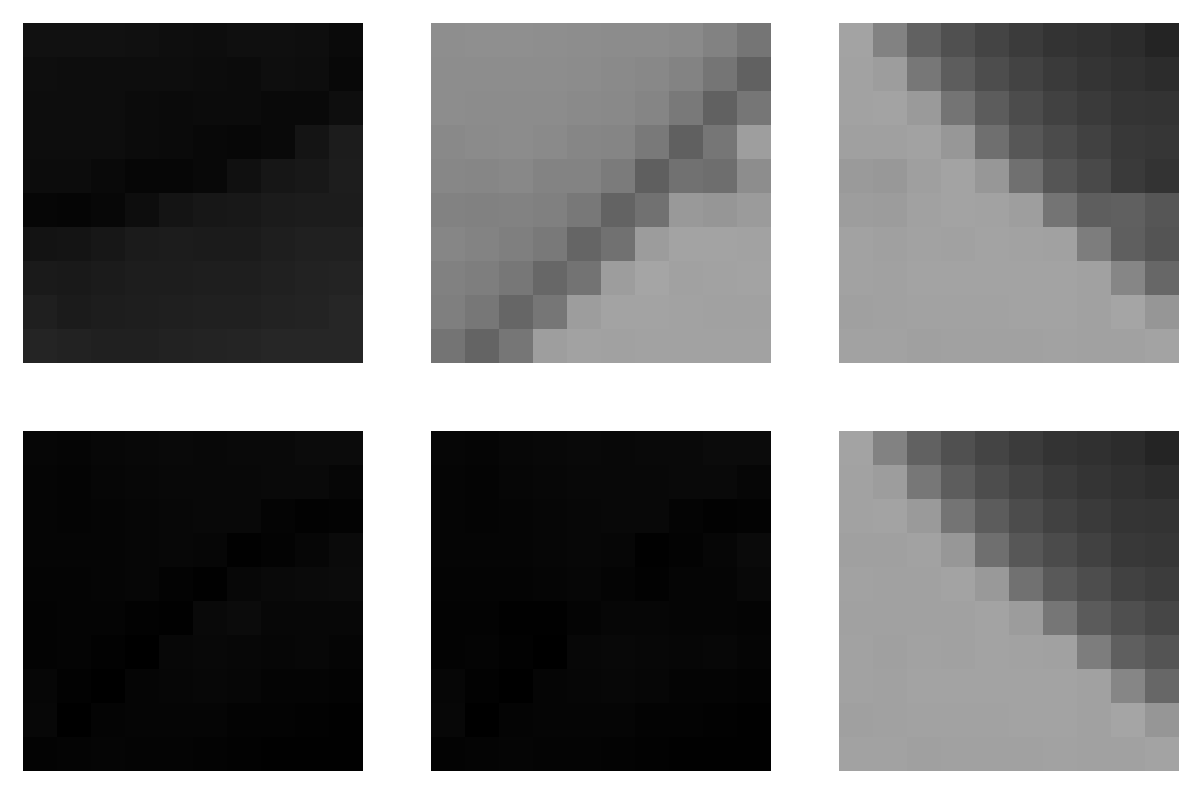

100%|██████████| 315/315 [03:14<00:00,  1.62it/s]




Time for epoch 220 is 200.01395344734192 sec
Discriminator loss: 0.688, Generator loss: 0.710.




  4%|▍         | 12/315 [00:08<03:35,  1.40it/s]


KeyboardInterrupt: 

In [87]:
trainLoader = torch.utils.data.DataLoader(
    dataset=trainSet,
    batch_size=TCfg.batchSize,
    shuffle=True,
    num_workers=os.cpu_count()
)

trainGen=True
trainDis=True
#fillWheights(generator.body)
#fillWheights(discriminator.body)
#fillWheights(discriminator.head)
train(trainLoader, TCfg.nofEpochs)

## <font style="color:lightblue">Post</font>

In [ ]:
randIdx = random.randint(0,len(testSet)-1)
image = testSet[randIdx]
plt.imshow(image.squeeze().transpose(0,1), cmap='gray')
plt.axis("off")
plt.show()

#image = image.to(TCfg.device)
#fake_image = generate_images(image)
#plt.imshow(fake_image.detach().squeeze().transpose(0,1), cmap='gray')
#plt.axis("off")
#plt.show()

addToHDF(f"test_{TCfg.exec}.hdf", "data", image)


In [ ]:
save_model(generator, TCfg.device, model_path=f"model_{TCfg.exec}_gen.pt")
save_model(discriminator, TCfg.device, model_path=f"model_{TCfg.exec}_dis.pt")
#save_model(generator, TCfg.device, model_path="saves/work_1.GEN.pt")
#save_model(discriminator, TCfg.device, model_path="saves/work_1.DIS.pt")